In [1]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pylab

In [125]:
data=np.load('Control/DsRed2-HeLa_11_21_3.npz')
vals,vecs=data['eigen_vals'],data['eigen_vecs']
index=np.argsort(vals)

In [126]:
'''
Get the trailing elements of input x

@param x a 2nd order tensor with frames along the first axis
@param f the particular frame to pull from
@param i the parameter which determines how many trailing elements to pull
'''
def getTrail(x,f,i=10):
    return x[f,index[f,:i]]

In [127]:
'''
Get the trailing elements of input x as a series iterating over frames

@param x a 2nd order tensor with frames along the first axis
@param f the parameter which determines how many frames to process
@param i the parameter which determines how many trailing elements to pull
'''
def getTrailSeries(x,f,i=10):
    out=np.zeros((f,i))
    for k in range(f):
        out[k]=getTrail(x,k,i)
    return out

In [128]:
'''
Creates a lineplot leveragin getTrailSeries

@param x a 2nd order tensor with frames along the first axis
@param f the parameter which determines how many frames to process
@param i the parameter which determines how many trailing elements to pull
'''

def makeLine(x,f,i=10):
    fig=go.Figure()
    t=np.linspace(1,f,f)
    data=getTrailSeries(x,f,i)
    for k in range(1,i):
        fig.add_trace(go.Scatter(x=t, y=data[:,k]))
    return fig

In [129]:
'''
Convert the data array into a fourier spectrum and display as a bar plot.
Note that we assume that the samples are collected over unit time, hence
the implicit sample frequency is #frames Hz. Note that in displaying the
spectra, if scaled then the constant term (freq 0) is omitted.

@param data a 2nd order tensor with frames along the first axis
@param i the parameter which determines how many trailing elements to pull.
       Note that the lowest trailing element, 0, is skipped.
@param cutoff the proportion (1/cutoff) of frequencies to display. That is
       to say, the output will display frequencies [0,#frames//(2*cutoff)]
@param scale if true, then the spectrum for each eigenvalue is scaled so
       that its value at freq 0 (constant) is 1. That is to say, the spectrum
       amplitudes become proportional to the amplitude of freq 0.
'''

def makeFourier(data,i=10,cutoff=5,scale=True):
    fig=go.Figure()
    N=len(data)
    data=data/data[:,1:2]
    
    #Freq space assuming eigenvalues sampled 
    #uniformally over unit time
    freq = np.linspace(0, 1, N)
    data=np.fft.rfft(data,axis=0)
    data=np.abs(data)/N
    if(scale):
        data=data/data[:1,:]

    for k in range(1,i):
        fig.add_trace(go.Bar(x=freq, y=data[1 if scale else 0:len(data)//cutoff,k]))
    return fig


In [130]:
'''
Dynamic thresholding algorithm which asserts that the signal is a gaussian 
sampled process. It then calculates the approximate z scores of new samples
based on a rolling window average whose size is specified by [lag].

@param y The input array to the algorithm. Should be a simple 1D numpy array.
@param lag Describes how 'smoothed' and 'adaptive' the thresholding is. Choose
       higher lag values for data that won't vary significantly over time, and
       a lower value for when data will reflect sudden changes.
@param threshold How many standard deviations out should a signal be considered
       a 'spike'. Higher values make the system more tolerant to noise, but
       naturally decrease sensitivity as well
@param influence A value [0,1] that describes how sensitive system is to state changes induced by
       spikes. That is to say, if a spike means that your signal behaviour will 
       totally change, then influence should be set to 1, however if your system
       dynamics remain static regardless of spikes, it should be set to 0
'''
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [153]:
'''
Calculates the spikes in various signals, then carries out a majority vote.
Results are then smoothed out by adjacency to remove artifacts.

@param x The input array to the algorithm. Should be a simple 1D numpy array.
@param f the parameter which determines how many frames to process
@param i the parameter which determines how many trailing elements to vote with
@param lag Describes how 'smoothed' and 'adaptive' the thresholding is. Choose
       higher lag values for data that won't vary significantly over time, and
       a lower value for when data will reflect sudden changes.
@param threshold How many standard deviations out should a signal be considered
       a 'spike'. Higher values make the system more tolerant to noise, but
       naturally decrease sensitivity as well
@param influence A value [0,1] that describes how sensitive system is to state changes induced by
       spikes. That is to say, if a spike means that your signal behaviour will 
       totally change, then influence should be set to 1, however if your system
       dynamics remain static regardless of spikes, it should be set to 0
'''
def signalVote(x,f,i,lag=10,threshold=3.5,influence=.08):
    y = getTrailSeries(x,len(x),i)
    results=np.zeros((i,f))
    for j in range(1,i):
        results[j-1] = thresholding_algo(y[:,j], lag=lag, threshold=threshold, influence=influence)['signals']
    results=np.sum(results,axis=0)
    results=np.rint(results/(i-1))
    out=np.zeros_like(results)
    for j in range(1,f-1):
        out[j]=round((results[j-1]+results[j]+results[j+1])/3)
    return out

In [154]:
'''
Calculates the spikes in various signals both forwards and backwards
in time, then carries out a majority vote. Note that the 'symmetric'
part of this technique is going in both directions of time, but that
is not to say that you'll get an identical ouptut when using x[::-1].
In fact, symSiganlVote(x[::-1],...)=-symSiganlVote(x,...) so it's
actually *antisymmetric* with respect to time.
Results are then smoothed out by adjacency to remove artifacts.

@param x The input array to the algorithm. Should be a simple 1D numpy array.
@param f the parameter which determines how many frames to process
@param i the parameter which determines how many trailing elements to vote with
@param lag Describes how 'smoothed' and 'adaptive' the thresholding is. Choose
       higher lag values for data that won't vary significantly over time, and
       a lower value for when data will reflect sudden changes.
@param threshold How many standard deviations out should a signal be considered
       a 'spike'. Higher values make the system more tolerant to noise, but
       naturally decrease sensitivity as well
@param influence A value [0,1] that describes how sensitive system is to state changes induced by
       spikes. That is to say, if a spike means that your signal behaviour will 
       totally change, then influence should be set to 1, however if your system
       dynamics remain static regardless of spikes, it should be set to 0
'''
def symSignalVote(x,f,i,lag=10,threshold=3.5,influence=.08):
    y1=signalVote(x,f,i,lag=lag,threshold=threshold,influence=influence)
    y2=signalVote(x[::-1],f,i,lag=lag,threshold=threshold,influence=influence)
    y=y1-y2
    y[y>0]=1
    y[y<0]=-1
    return y

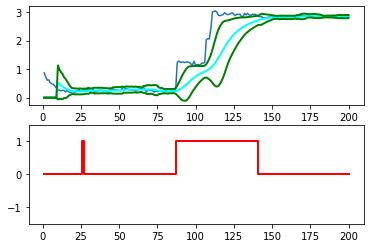

In [155]:
'''
Signal Demo

'''

# Data
y = getTrailSeries(vals,len(vals),6)[:,1]

# Settings. See https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/ for details
lag = 10
threshold = 3.5
influence = 0.075

# Run algo with settings from above
result = thresholding_algo(y[::1], lag=lag, threshold=threshold, influence=influence)

# Plot result
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y[::1])

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"], color="cyan", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

pylab.subplot(212)
pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
pylab.ylim(-1.5, 1.5)
pylab.show()


In [156]:
# Works best for small k, e.g. 3-8
k=8
# Generate signals of the first k eigenvalues
# and then calculate majority vote
vote_result=symSignalVote(vals,len(vals),k,influence=.08)
trace1 = {
  "x": np.linspace(1,len(vals),len(vals)),
  "y": vote_result,
  "line": {"shape": 'hv'},
};
sig=go.Scatter(trace1)

# Make a line plot of the trailing eigenvalues
makeLine(vals,len(vals),k).add_trace(sig).show()
'''
# Fourier analysis of the trailing eigenvalues
data=getTrailSeries(vals,len(vals),k+1)
makeFourier(data,k,1).show()

# Look at the differences between eigenvalues
# Otherwise known as eigengaps
# eigengap_k=eigenvalue_k-eigenvalue_k+1
data=np.diff(data)

# Fourier analysis of the differences
makeFourier(data,k,5,scale=False).show()
'''
print()

# Note
It when presenting video highlights, it benefits to look at the period of time *immediately preceeding* a signal spike since that will likely capture the causal event.